## Hepatitis C Analysis
---

### Clinical laboratory manifestations:
##### <u>Serum LFTs</u>
1) Alkaline phosphatase (ALP):
* generically found in liver and other organs (require concomitant GGT increase for confirmed liver source)
* up to 4-6x normal limit
2) Gamma-glutamyl transpeptidase (GGT): in liver exclusively
3) Aspartate transaminase (AST): released due to hepatocyte damage
4) Alanine transaminase (ALT): released due to hepatocyte damage
5) Bilirubin (BIL)
6) Albumin (ALB)
7) Creatinine (CREA)
8) Cholesterol (CHOL): ? decreases with age 
(https://bmcinfectdis.biomedcentral.com/articles/10.1186/s12879-015-1268-2)
9) Cholinesterase (CHE): specific type is pseudocholinesterase which assesses liver function
10) Blood protein level (PROT)

#### <u>Normal range</u>
|Test|Range|
|---|---|
|ALB|34-50 g/L|
|BIL|<19 mmol/L|
|ALT|<45 U/L|
|AST|<35 U/L|
|ALP|35-120 U/L
|GGT|<70 U/L|
|CREA|(M) 62-115, (F) 53-97 umol/L|
|CHE|8-18 U/mL|
|CHOL|<4 mmol/L|
|PROT|60-83 g/L|

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
import re
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC

import xgboost as xgb
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings("ignore")

#### Required functions

In [2]:
def is_out_range(ser, gender, n_rng):
    if ser.name == 'CREA':
        tmp = pd.concat([gender, ser], axis=1)
        _low_m, _high_m, _low_f, _high_f = n_rng.loc['CREA-M']['Lower'], n_rng.loc['CREA-M']['Upper'], n_rng.loc['CREA-F']['Lower'], n_rng.loc['CREA-F']['Upper']
        sel_out_m = (tmp['Sex'] == 'm') & (tmp[ser.name] <= _high_m) & (_low_m <= tmp[ser.name])
        sel_out_f = (tmp['Sex'] == 'f') & (tmp[ser.name] <= _high_f) & (_low_f <= tmp[ser.name])
        return np.where((sel_out_m | sel_out_f), 0, 1)
    else:
        _low, _high = n_rng.loc[ser.name]['Lower'], n_rng.loc[ser.name]['Upper']
        return np.where((ser < _high) & (ser > _low), 0, 1)
    
def gen_plots(data, var1='', var2='', mode_type='bi-var', cols='all', **kwargs):
    if (mode_type == 'bi-var') & (var1 != '') & (var2 !=''):
        # fig, ax = plt.subplots(figsize=(26,10))
        g = sns.FacetGrid(data, row='Sex', col='Category Name', hue='Age Bins', height=5)
        g.map(sns.scatterplot, var1, var2)
        g.add_legend()
    elif mode_type == 'pairplot':
        if cols == 'all':
            pass
        else:
            assert isinstance(cols, list)
            tmp = data[cols + ['Category Name']]
            ax = sns.pairplot(tmp, hue='Category Name', kind='scatter', diag_kind='kde', height=5)
    elif mode_type == 'barplot':
        def chart_rev(x, y, **kwargs):
            ax = sns.barplot(x,y,**kwargs)
            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.1f'), 
                            xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                            fontsize=12, 
                            xytext=(0,10), 
                            textcoords="offset points", 
                            color=kwargs.get("color","k"), 
                            bbox=dict(pad=.9,alpha=0.2,color='none'), 
                            va='center', ha='center', weight='bold')
        g = sns.FacetGrid(data, row=kwargs.get('fac_row'), col=kwargs.get('fac_col'), height=7)
        g.map(chart_rev, var1, var2)
            
def get_rmse_acc(model, y_test, X_test, tmp_rmse_list, tmp_acc_list):
    tmp_rmse = round(sqrt(mean_squared_error(y_test, model.predict(X_test))), 3)
    tmp_acc = round((model.predict(X_test) == y_test).sum() / y_test.shape[0], 3)
    tmp_rmse_list.append(tmp_rmse)
    tmp_acc_list.append(tmp_acc)
    return (tmp_rmse, tmp_acc, tmp_rmse_list, tmp_acc_list)

#### Set-up range boundaries

In [3]:
normal_rng = {
    'Test': ['ALB', 'BIL', 'ALT', 'AST', 'ALP', 'GGT', 'CREA-M', 'CREA-F', 'CHE', 'CHOL', 'PROT'],
    'Lower': [34, 0, 0, 0, 35, 0, 62, 53, 8, 0, 60],
    'Upper': [50, 19, 45, 35, 120, 70, 115, 97, 18, 4, 83]
}
rng_df = pd.DataFrame(normal_rng).set_index('Test')

#### Read and preprocess data

In [4]:
df = pd.read_csv('hcvdat0.csv', index_col=0)

df_cat = df['Category'].str.split('=', expand=True).rename({0: 'Category ID', 1: 'Category Name'}, axis=1)
df2 = pd.concat([df, df_cat], axis=1).drop('Category', axis=1)

category_map = df2[['Category ID', 'Category Name']].drop_duplicates() \
                                                    .reset_index(drop=True) \
                                                    .drop(1) \
                                                    .reset_index(drop=True)

In [5]:
lft_cols = df2.columns[~df2.columns.str.contains('^Age|Sex|^Category')].tolist()
loop_list = list(permutations(lft_cols, r=2))

bin_edges = [df2['Age'].min() + 6*i for i in range(11)]
df2['Age Bins'] = pd.cut(df2['Age'], bin_edges, right=False)

In [6]:
df2['Age Bins 2'] = df2['Age Bins'].cat.rename_categories([re.sub('\[|\)', '', str(s)).replace(', ', '-') for s in df2['Age Bins'].cat.categories])
df2 = df2.drop('Age Bins', axis=1).rename({'Age Bins 2': 'Age Bins'}, axis=1)
df2 = df2.assign(**{col+'_IND': is_out_range(df2[col], df2['Sex'], rng_df) for col in lft_cols})

In [7]:
df3 = df2.copy()[['Sex', 'Category Name'] + lft_cols]
df3.replace({'0s': 0, 'suspect Blood Donor': 'Blood Donor'}, inplace=True)
avg_chars = df3.groupby(['Category Name', 'Sex']).mean().reset_index().melt(['Category Name', 'Sex'], var_name='Test', value_name='Value')

#### Visualize and analyze

Number of sampled patients by category
- Distribution of participated patients indicate a disproportionate weighting of "Blood Donor" participants compared to other categories

In [8]:
df2['Category Name'].value_counts().reset_index().rename({'index': 'Category Name', 'Category Name': '# Patients'}, axis=1)

,Category Name,# Patients
0,Blood Donor,533
1,Cirrhosis,30
2,Hepatitis,24
3,Fibrosis,21
4,suspect Blood Donor,7


Age distribution of different categorical patients for different clinical tests
- As an example, distributions are assessed against patient category for all combination of tests to ALB
- No specific trends identified among different binned age groups for Hepatitis patients

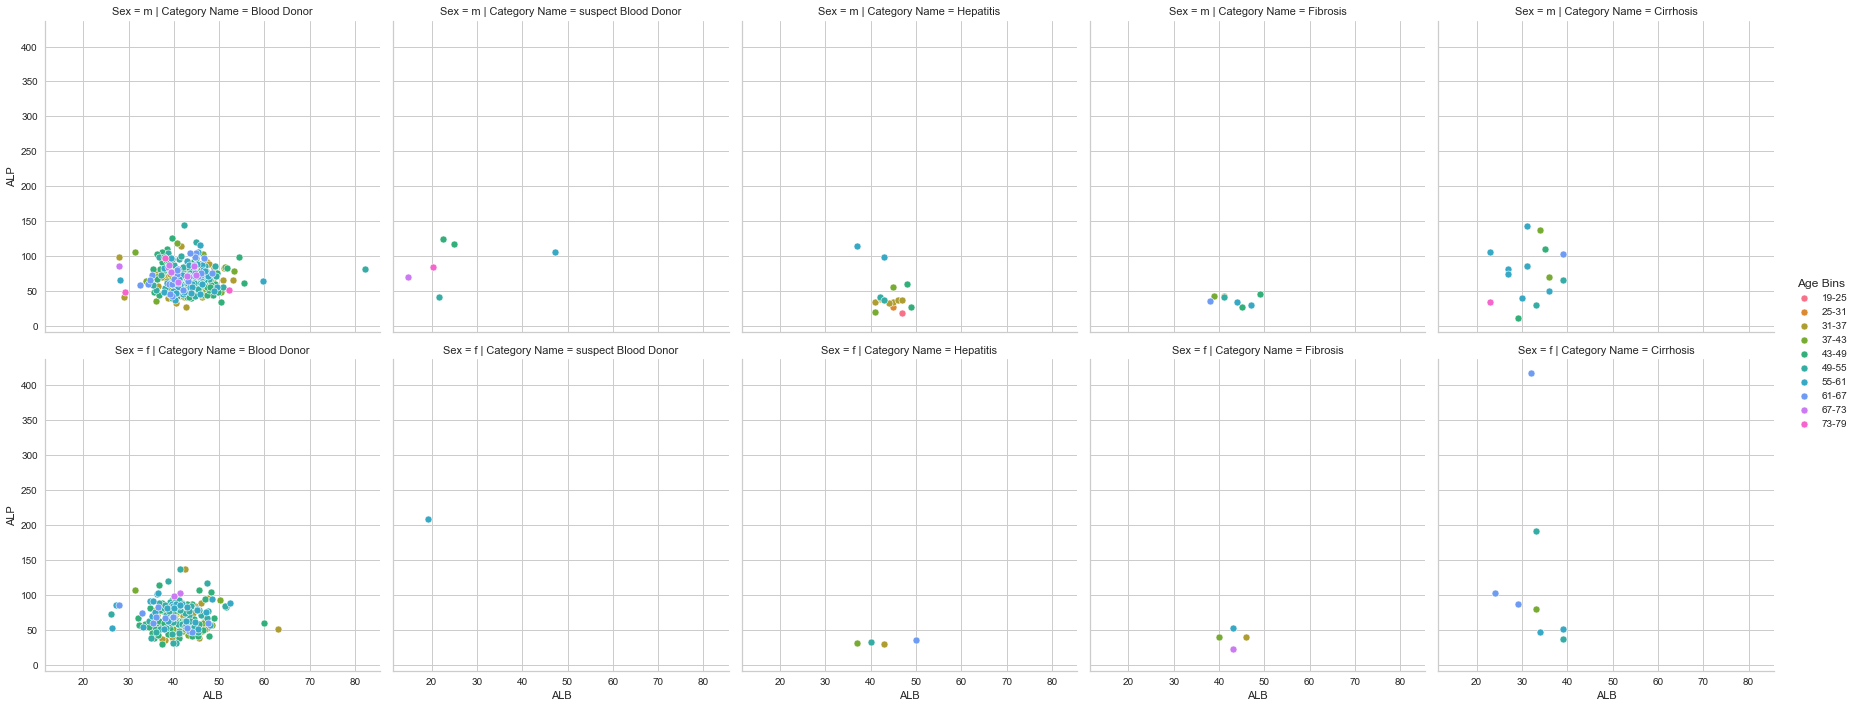

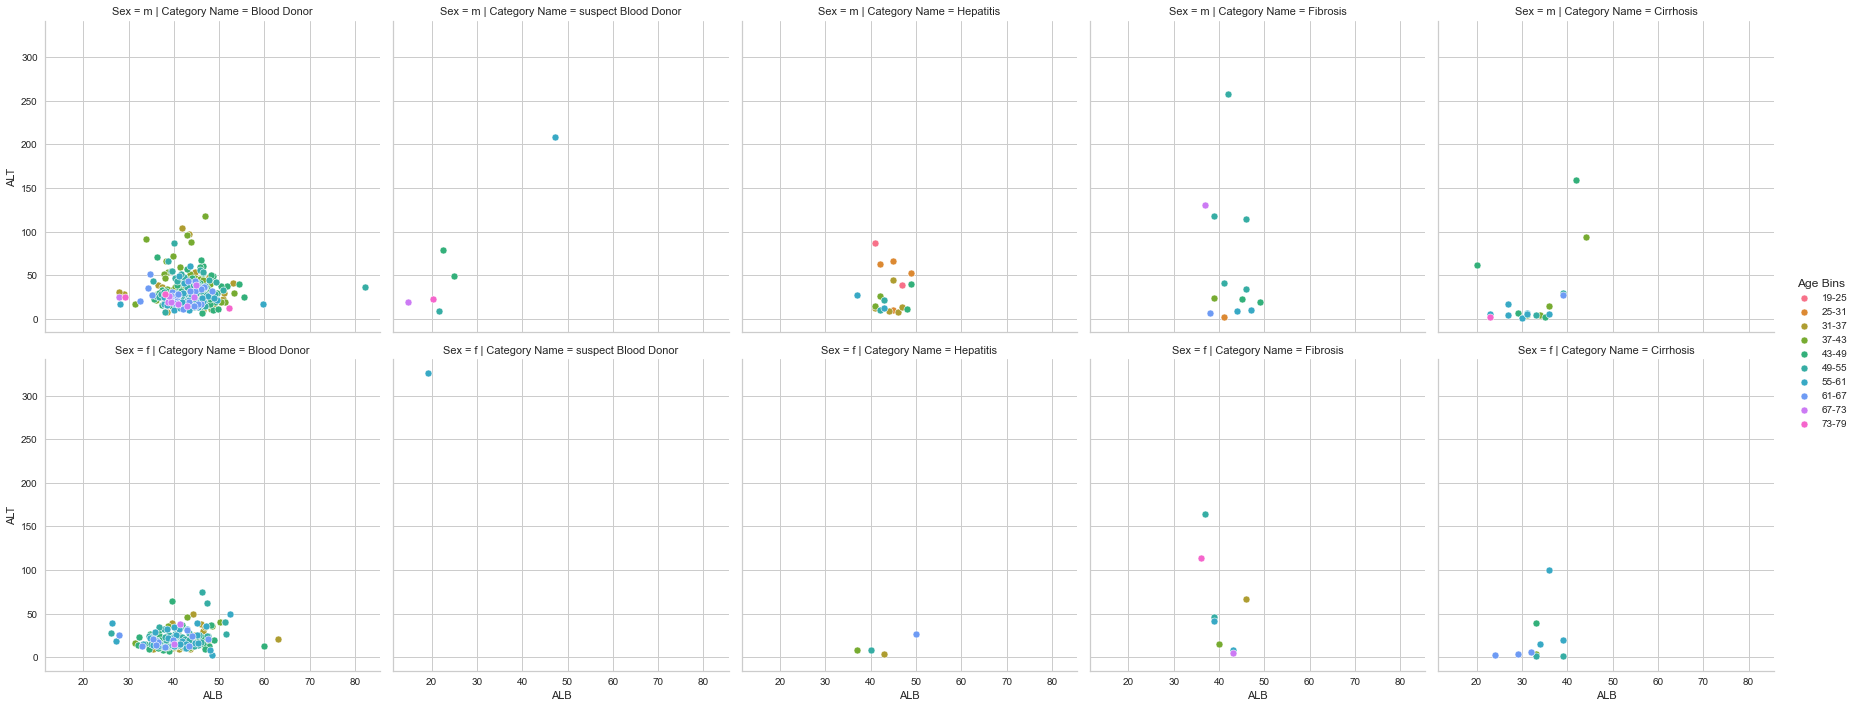

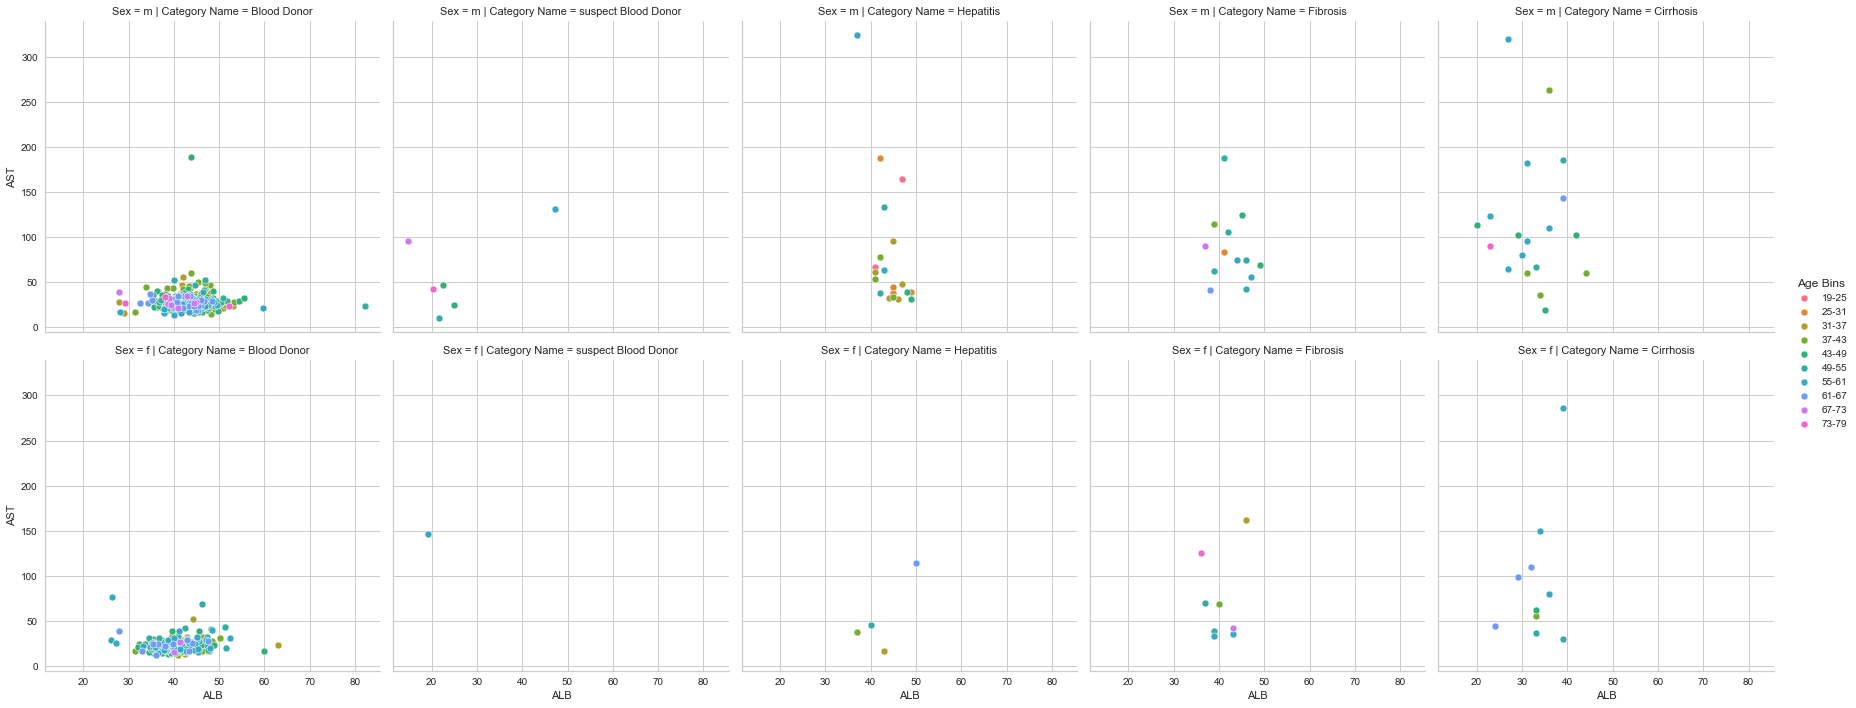

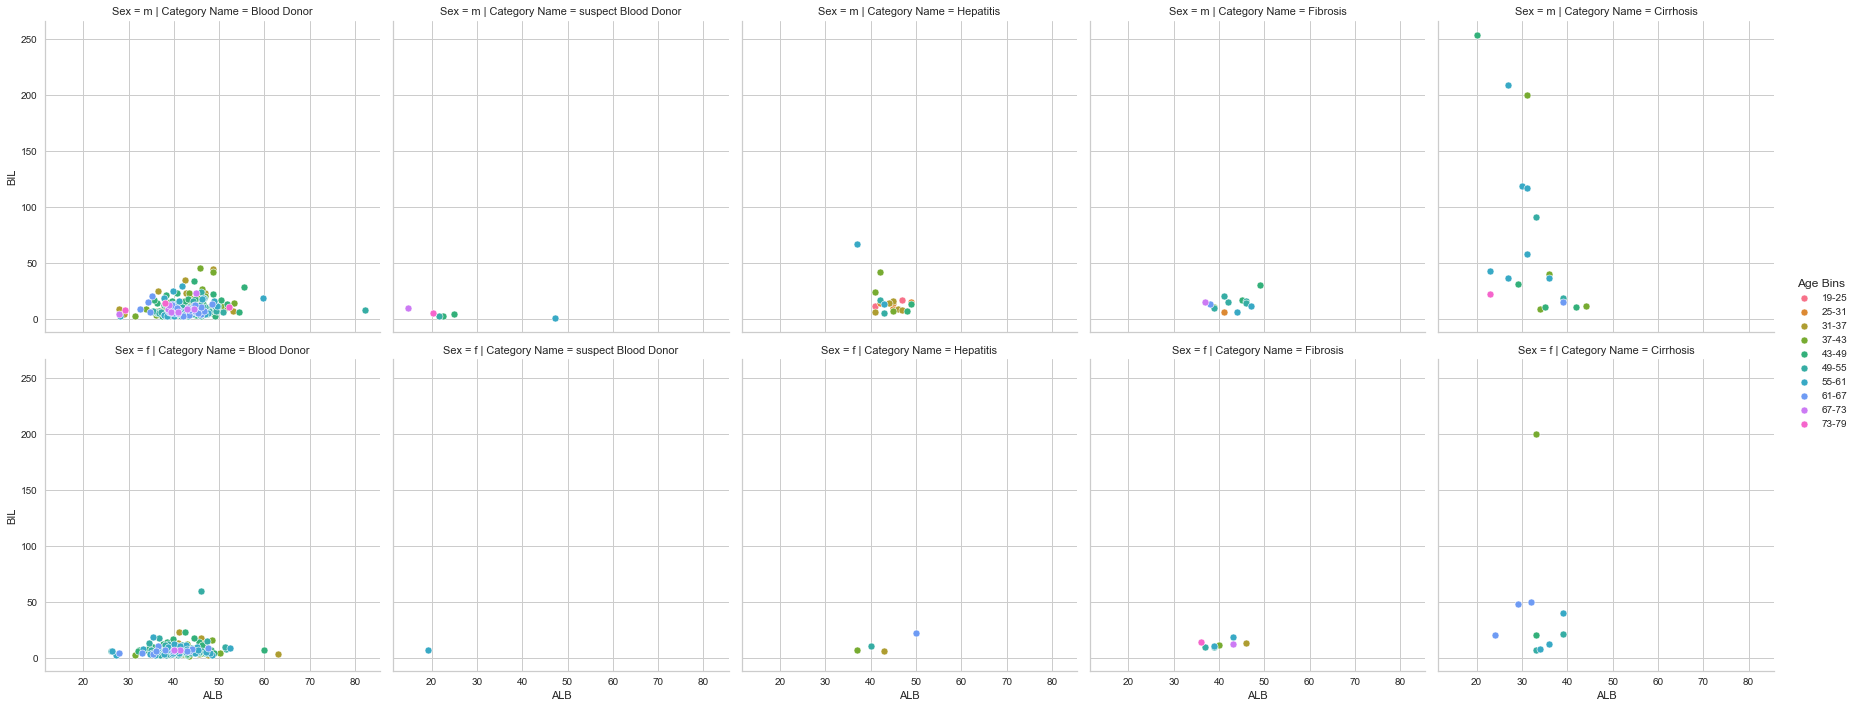

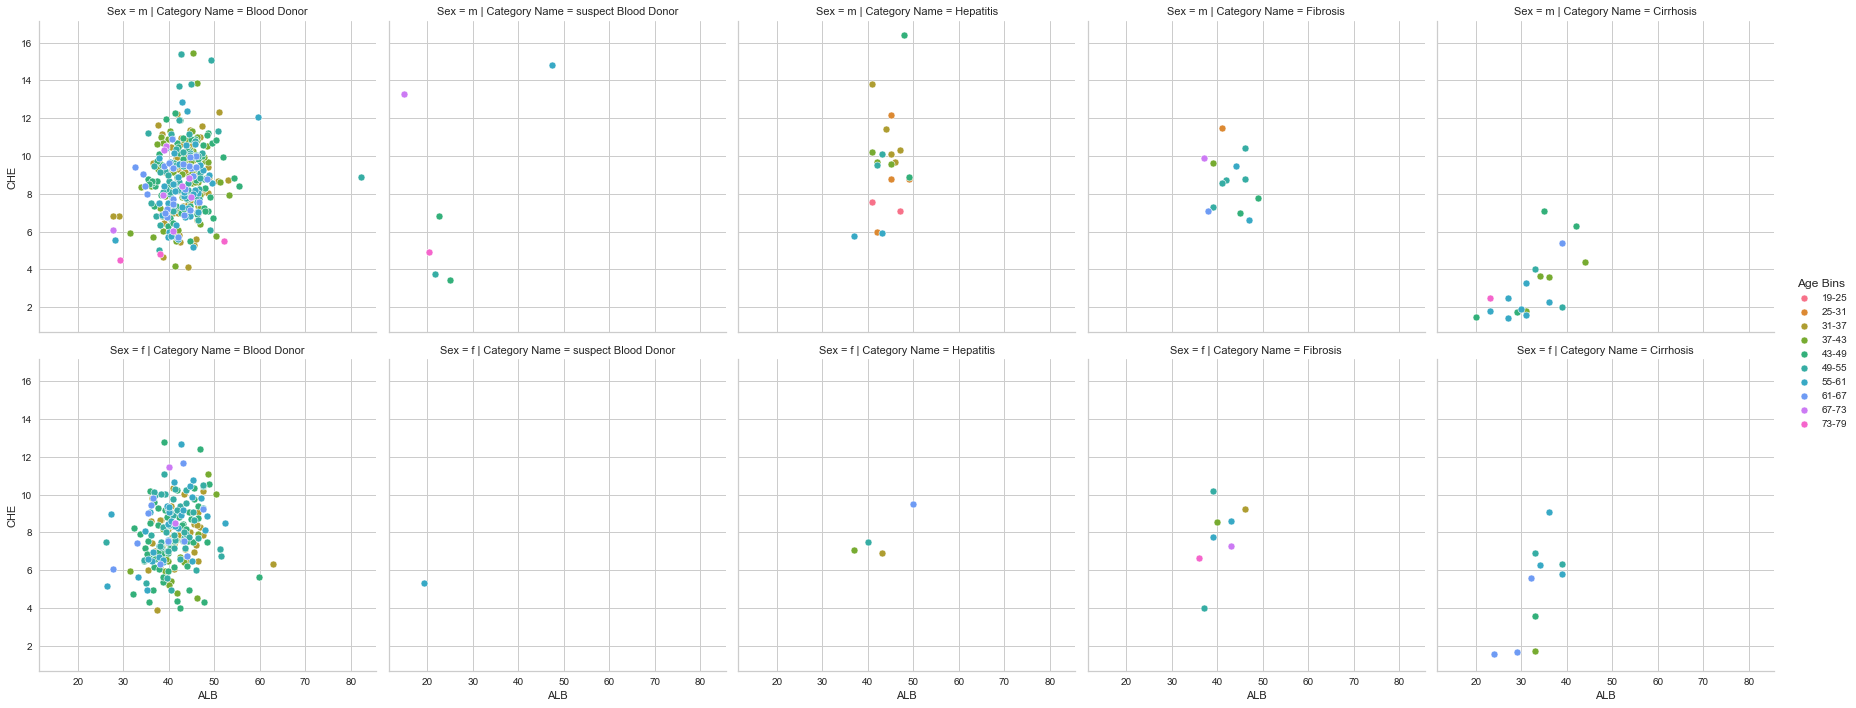

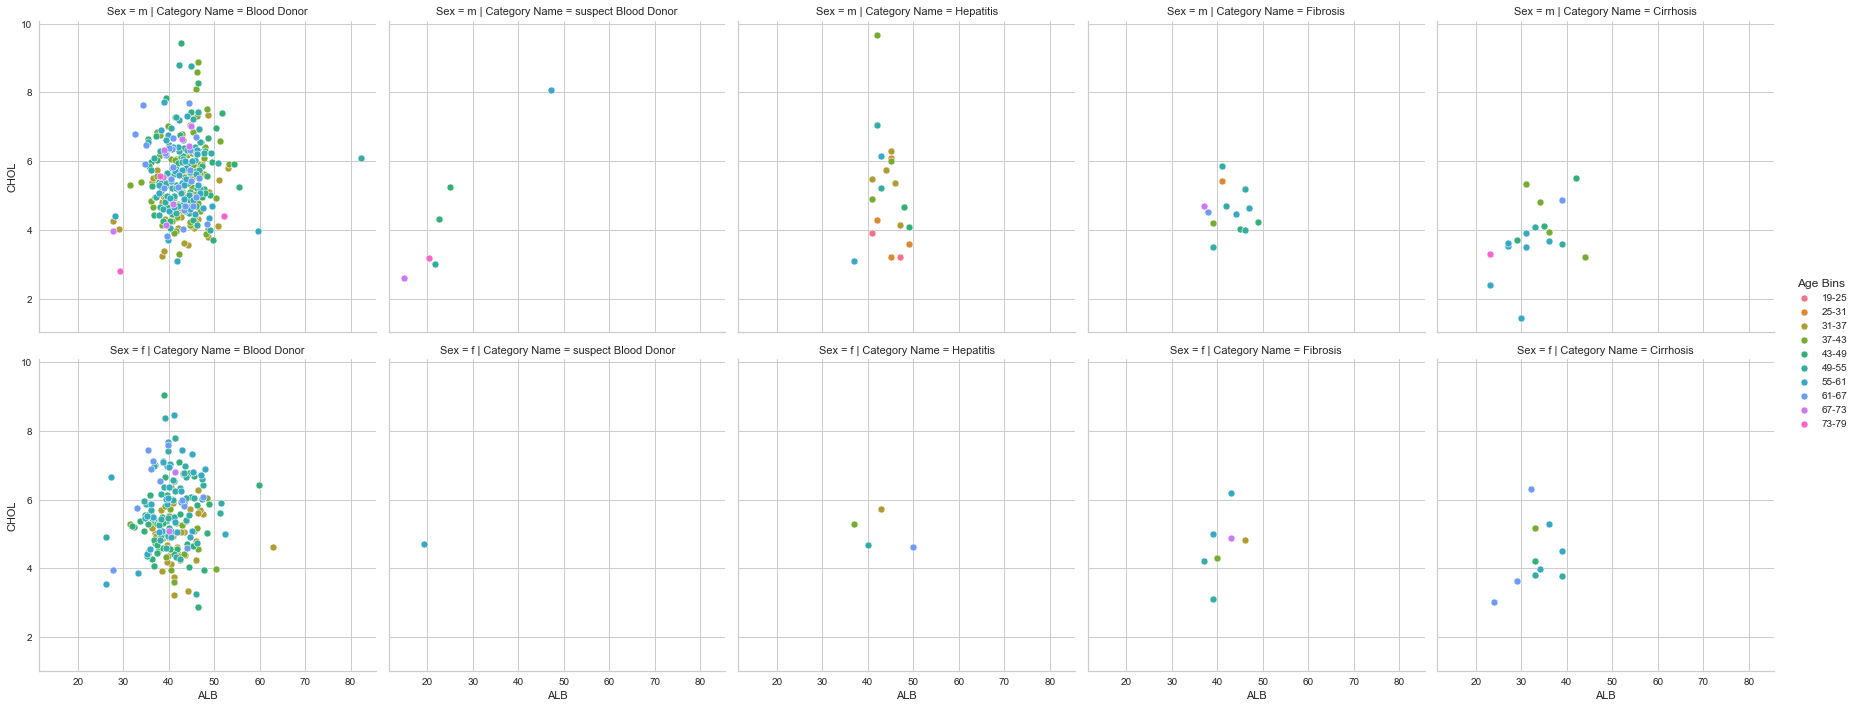

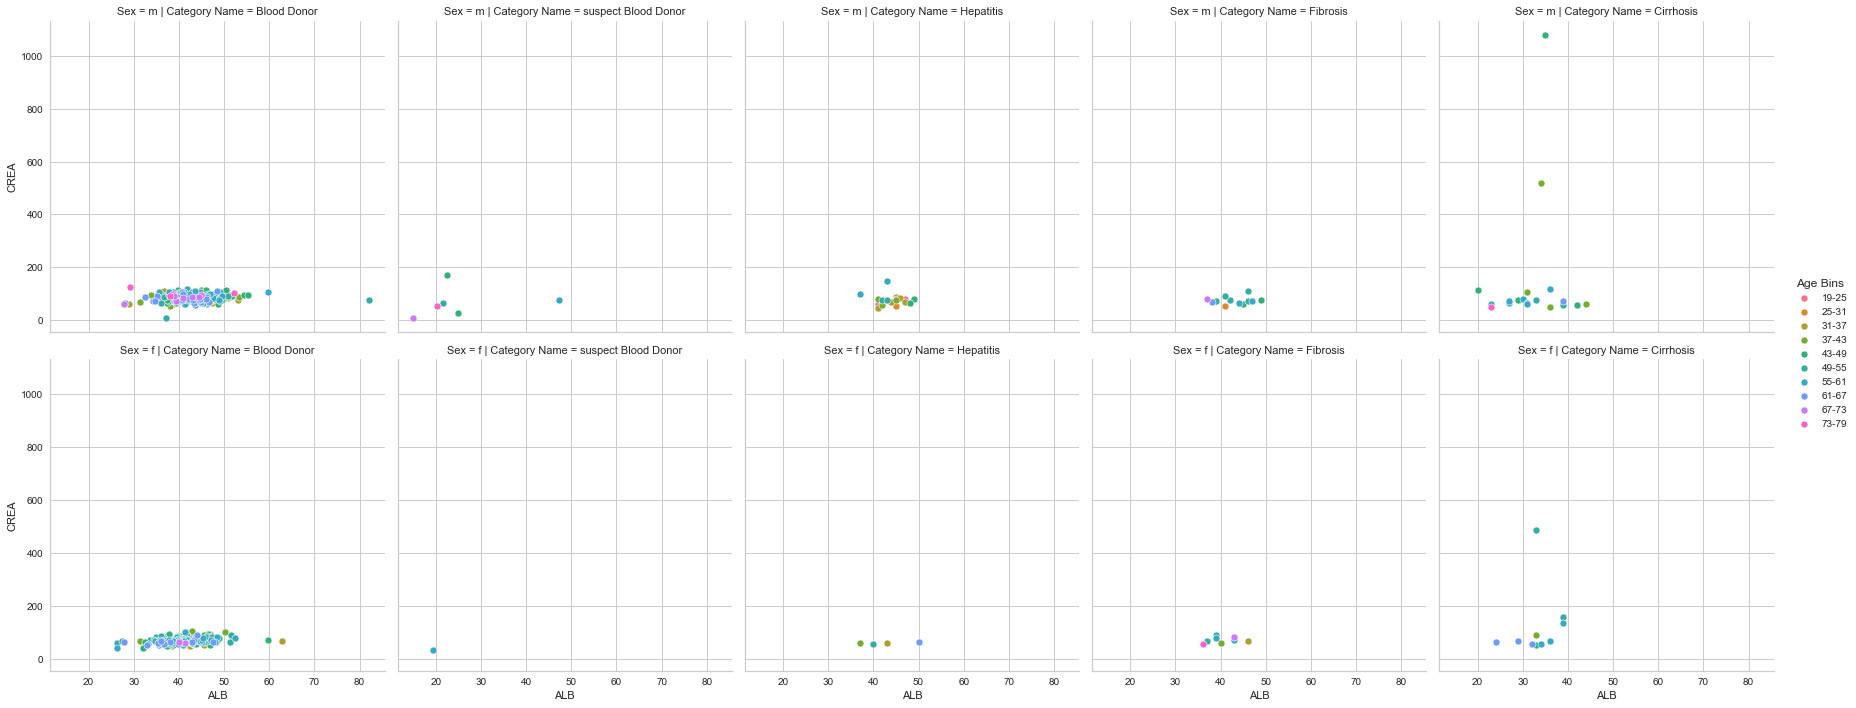

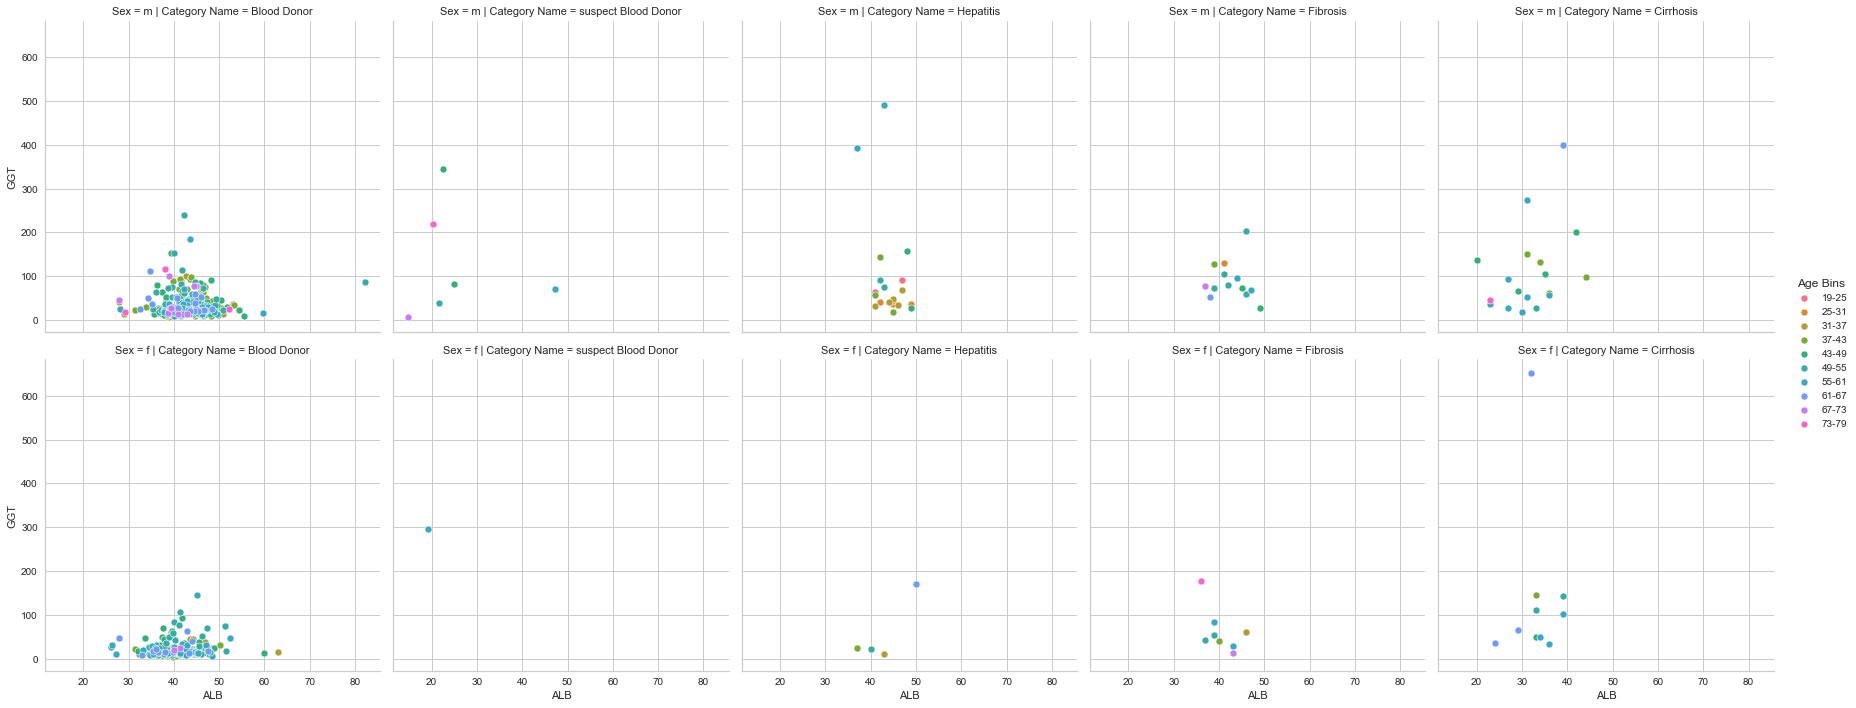

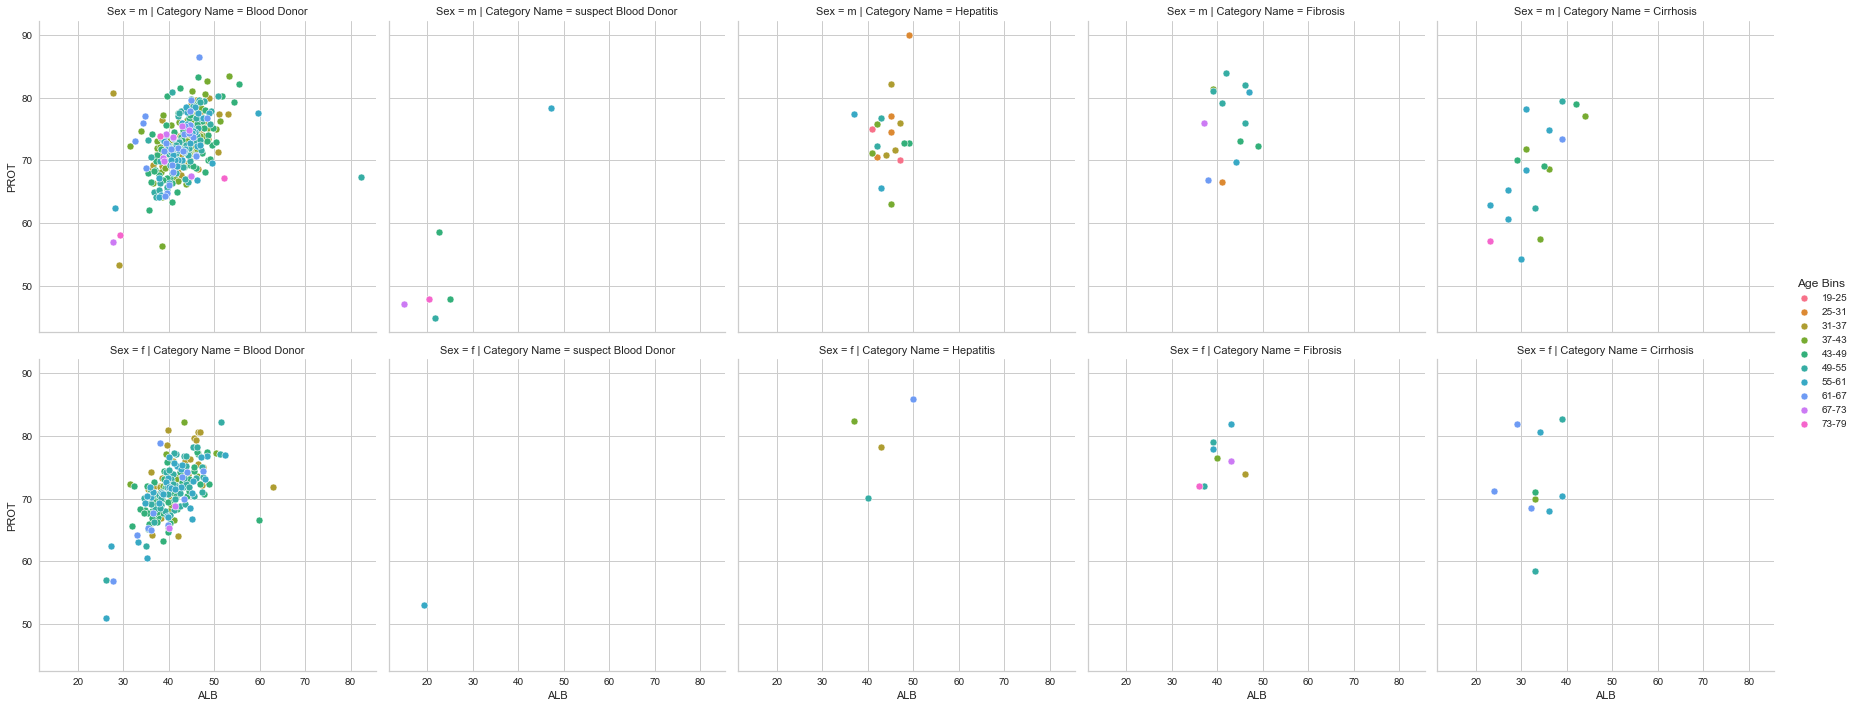

In [9]:
for var1, var2 in loop_list[:9]:
    gen_plots(df2, var1, var2)

ii) Distribution of clinical test variables between different patient categories
- For example, distributions are assessed against each of CHE, CHOL, CREA, GGT, and PROT test data
- Marker values of clinical tests for Hepatitis patients are scattered in random fashion among other non-Hepatitis patients

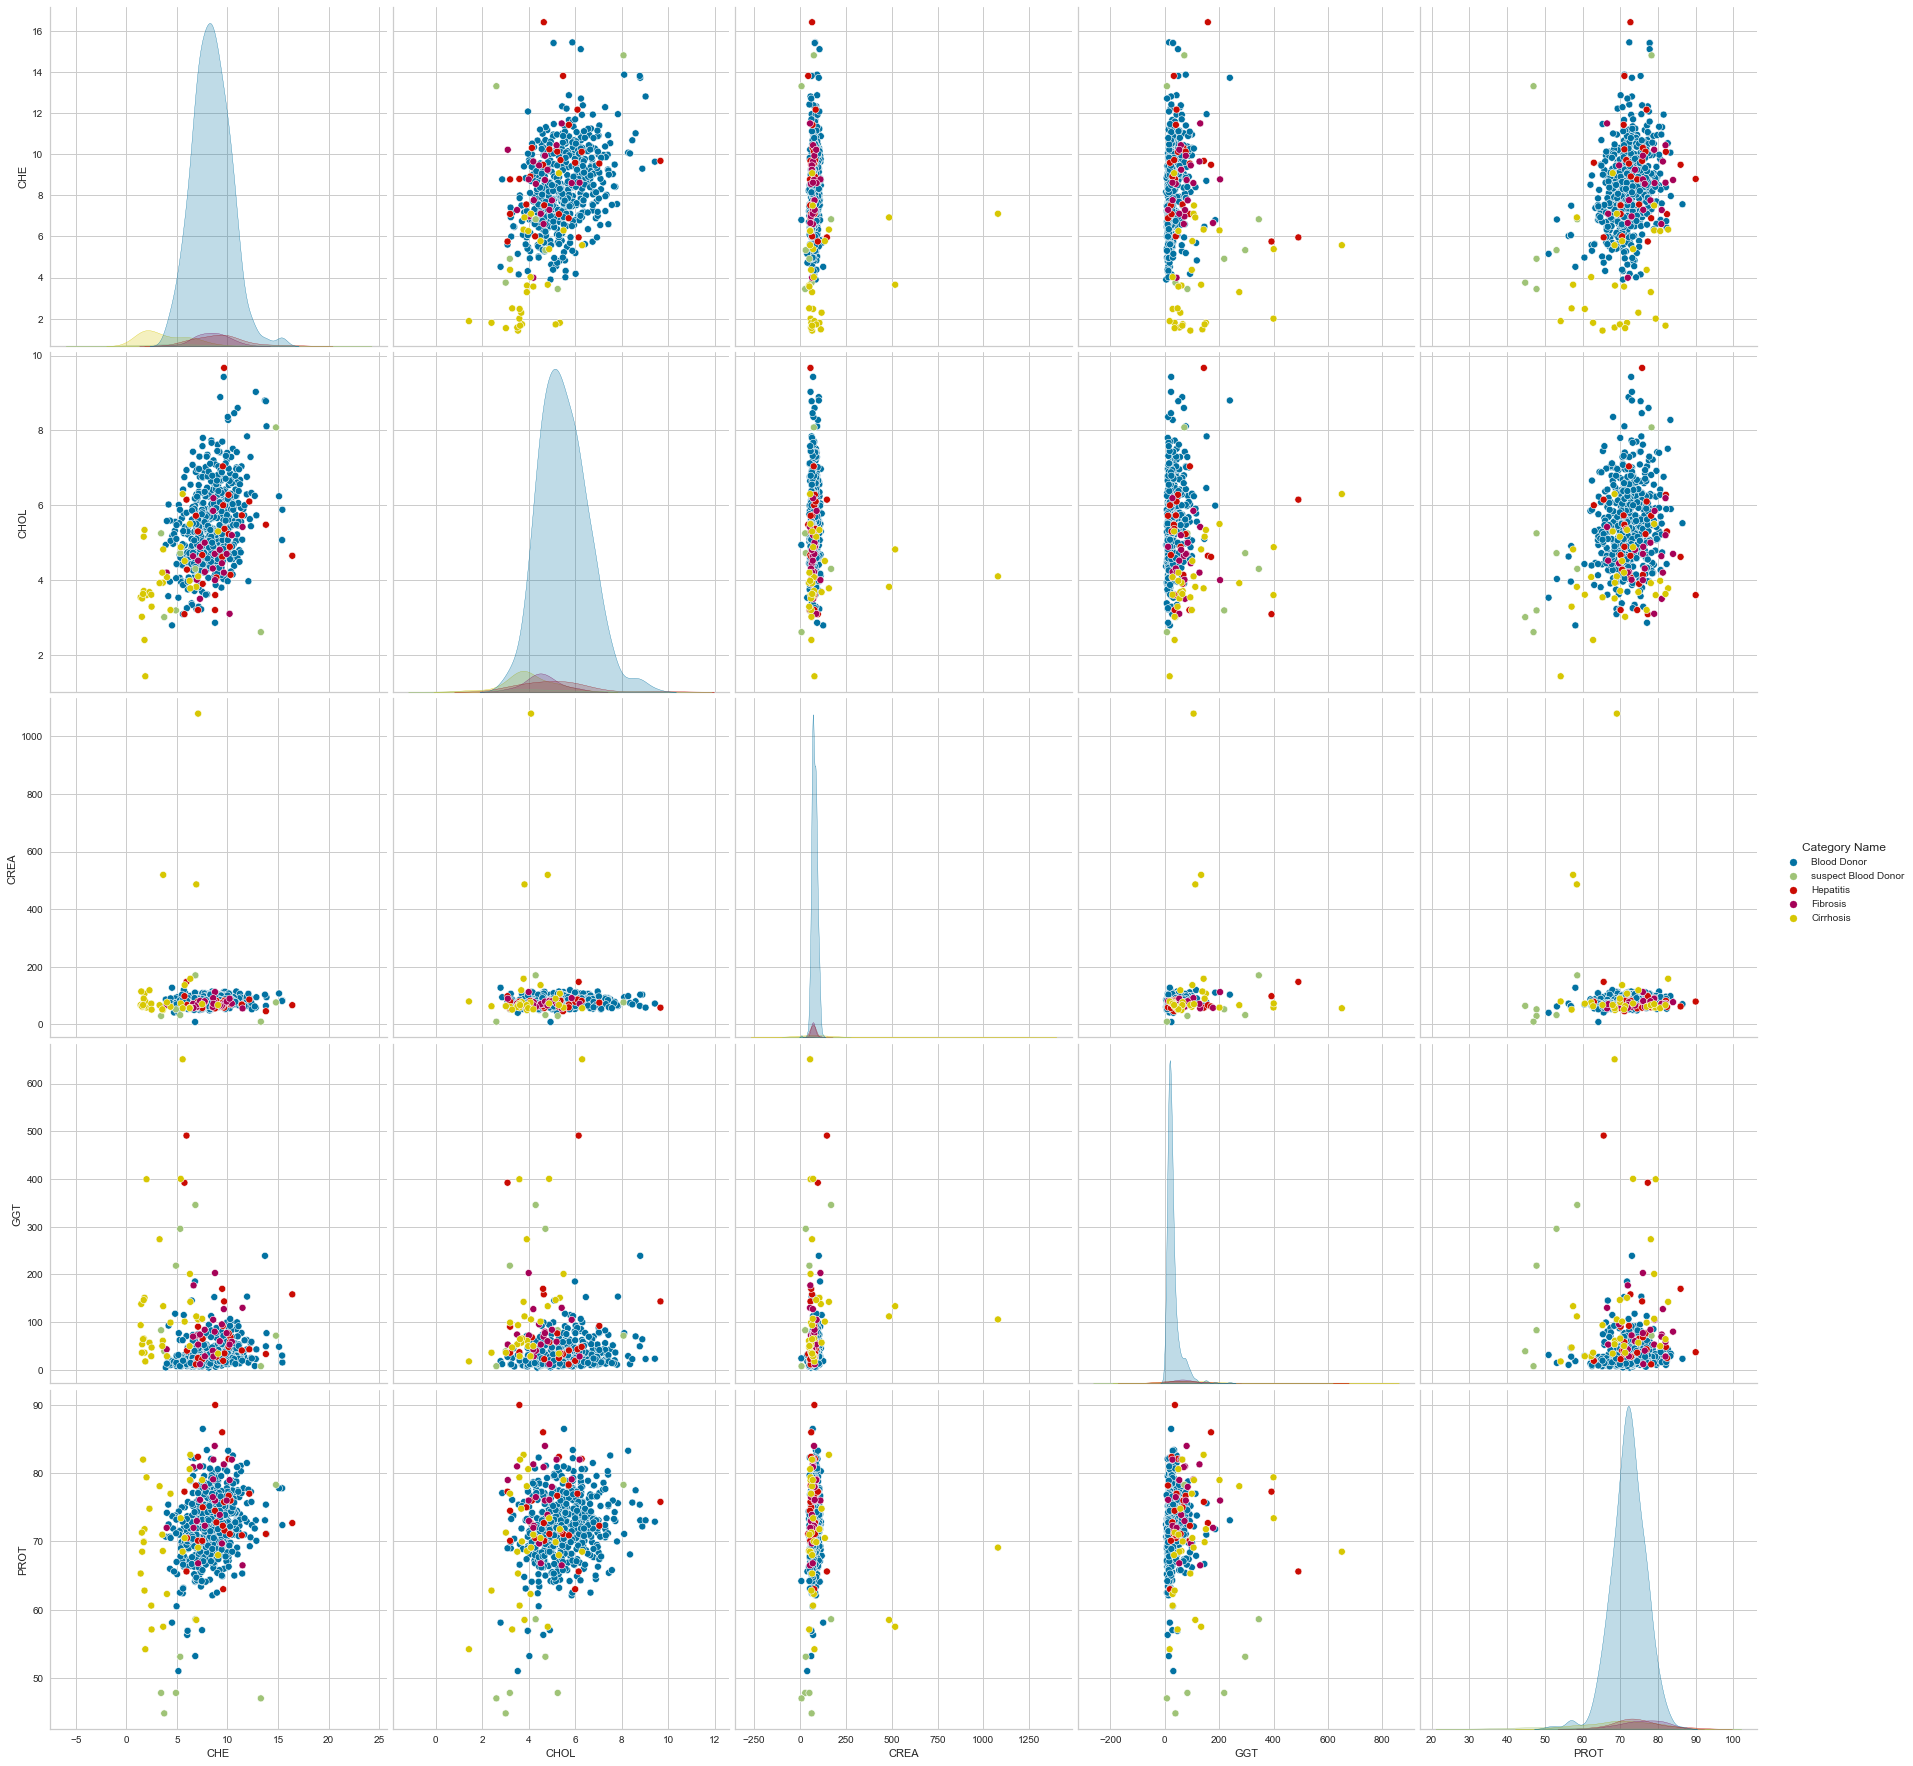

In [10]:
gen_plots(df2, mode_type='pairplot', cols=['CHE', 'CHOL', 'CREA', 'GGT', 'PROT'])

iii) Clinical test averages for sample data decomposed by patient category and sex
- Based on averages below, clinical profile of hepatitis patients appear similar to patients with fibrosis compared to other patient categories for both male and female
- A marked decrease in ALT levels for hepatitis as opposed to patients with fibrosis can be seen though whether this is a significant observation is yet to be assessed

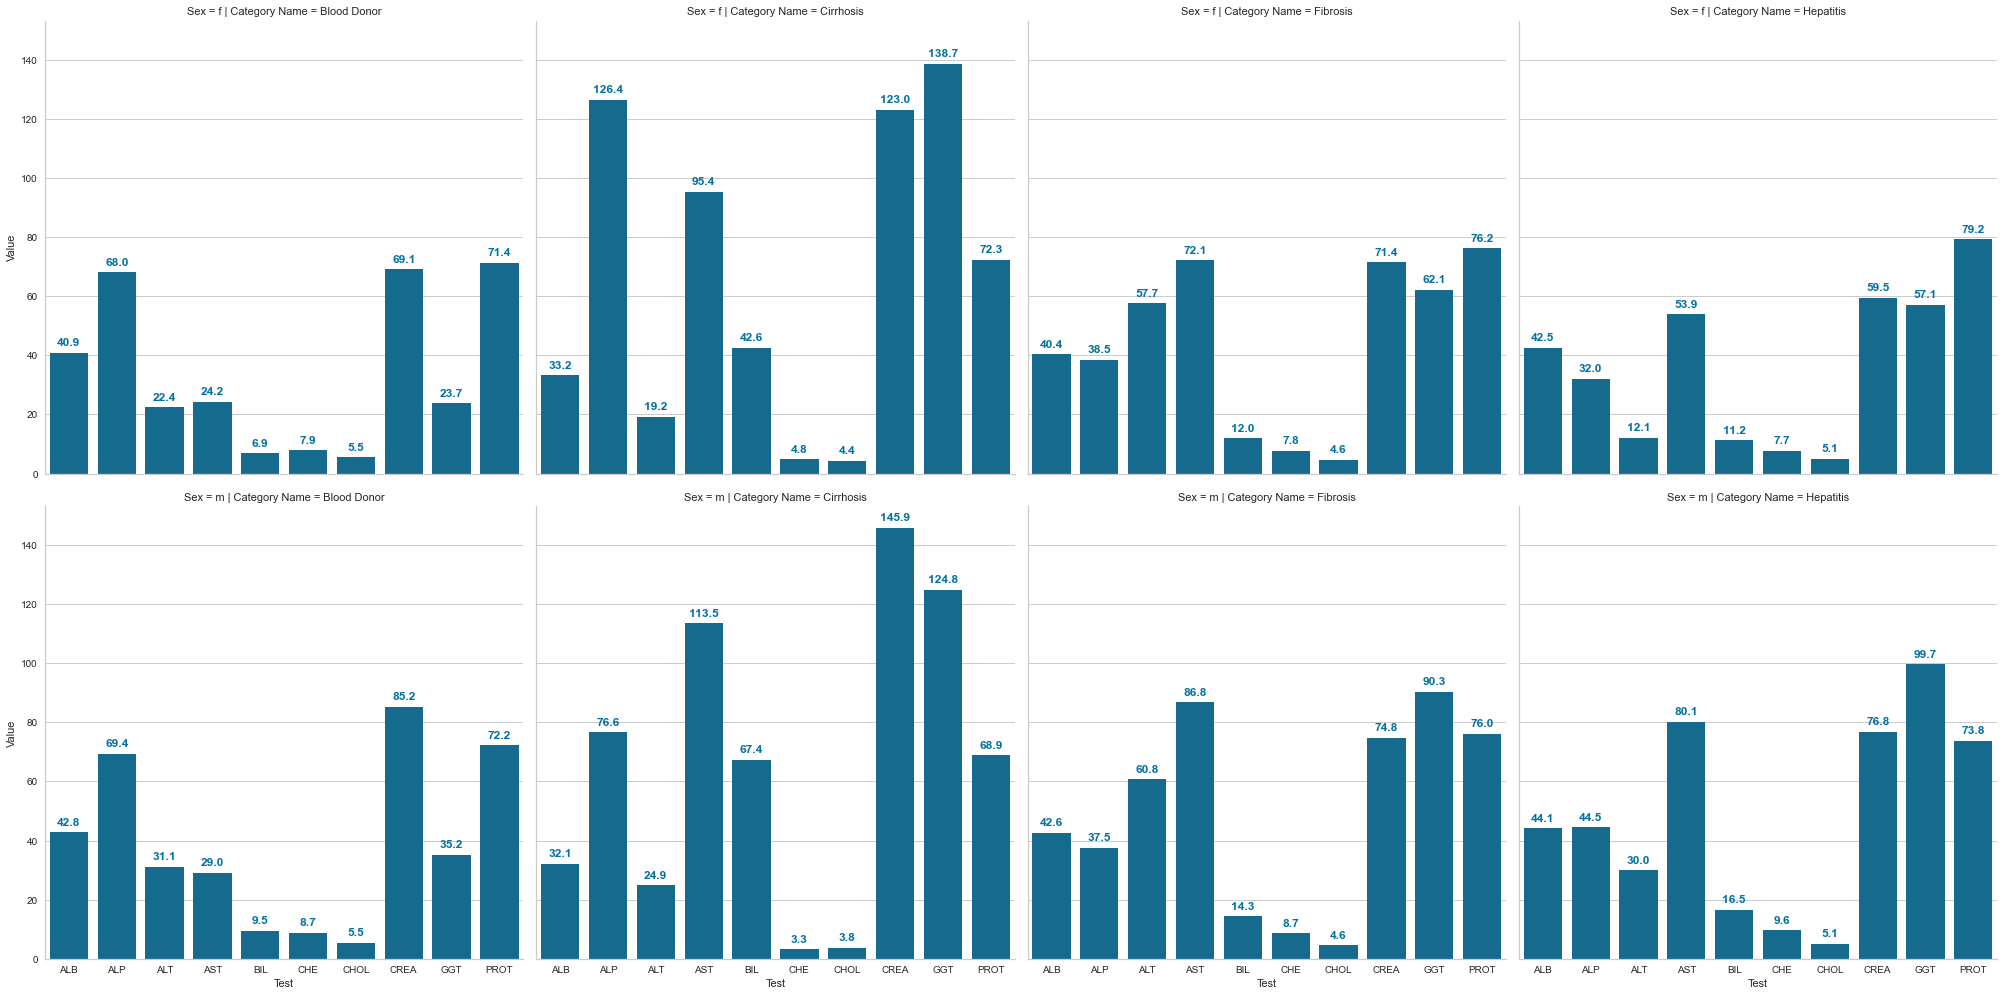

In [11]:
gen_plots(avg_chars, var1='Test', var2='Value', mode_type='barplot', fac_row='Sex', fac_col='Category Name')

### <u>Category prediction learning</u>
- In summary, best model of either K-NN, XGBoost, or support vector classifier in terms of higher overall model average (91.9%) and precision-specific metric to identify hepatitis individuals (100%): support vector classifer
- Further removal of non-critical variables via PCA prior to model optimization could improve model accuracy and performance

In [12]:
data = df2[['Age', 'Sex'] + lft_cols + ['Category ID']]
data['Sex'] = data['Sex'].replace({'m': 0, 'f': 1})
data.replace({'0s': 0, 'suspect Blood Donor': 'Blood Donor'}, inplace=True)
data['Category ID'] = data['Category ID'].astype(int)
data2 = data.copy()

In [13]:
rmse_list, acc_list = list(), list()

imputer = SimpleImputer()
data.loc[:, lft_cols] = imputer.fit_transform(data.loc[:, lft_cols])

ss = StandardScaler()
X, y = data.iloc[:, :-1], data.iloc[:, -1]
scaled_X = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.20, random_state=241)

#### <i>K-nearest neighbours</i>
#### a) Optimizing K
##### i) Method 1: GridSearch optimal parameters
- parameters:  K=3, distance metric: Manhattan

In [14]:
params = {
    'n_neighbors': range(2, 10),
    'p': [1, 2]
}
gs = GridSearchCV(KNeighborsClassifier(), params)
gs.fit(X_train, y_train)
knn_optim_1 = gs.best_estimator_

knn_optim_1_rmse, knn_optim_1_acc, rmse_list, acc_list = get_rmse_acc(knn_optim_1, y_test, X_test, rmse_list, acc_list)

##### ii) Method 2: Elbow method
- parameters: K=4, distance metric: Minkowski

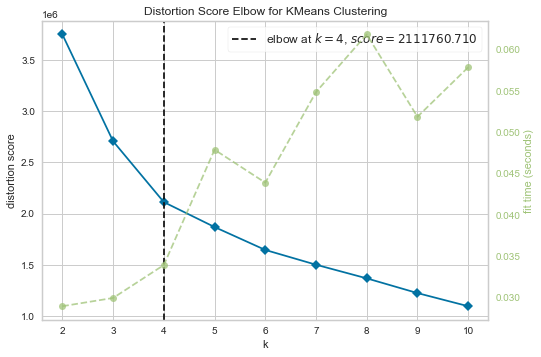

In [15]:
elbow_vis = KElbowVisualizer(KMeans(), k=10)
elbow_vis.fit(X)
elbow_vis.show();

In [16]:
elbow_c = KNeighborsClassifier(n_neighbors=4)
elbow_c.fit(X_train, y_train)

knn_optim_2_rmse, knn_optim_2_acc, rmse_list, acc_list = get_rmse_acc(elbow_c, y_test, X_test, rmse_list, acc_list)

#### b) Training summary

In [17]:
print('---- Accuracy evaluation for method a & b ----')
print('Method a:', f'\nRMSE: {knn_optim_1_rmse}', f'\nAccuracy: {knn_optim_1_acc}')
print('\nMethod b:', f'\nRMSE: {knn_optim_2_rmse}', f'\nAccuracy: {knn_optim_2_acc}')

---- Accuracy evaluation for method a & b ----
Method a: 
RMSE: 0.361 
Accuracy: 0.919

Method b: 
RMSE: 0.312 
Accuracy: 0.927


In [18]:
data2['Category Predicted KNN'] = elbow_c.predict(scaled_X)

print('Classification Report', 
      '\n---------------------\n', 
      classification_report(data2['Category ID'], data2['Category Predicted KNN'], target_names=category_map['Category Name']))

Classification Report 
---------------------
               precision    recall  f1-score   support

 Blood Donor       0.94      1.00      0.97       540
   Hepatitis       0.71      0.21      0.32        24
    Fibrosis       0.62      0.38      0.47        21
   Cirrhosis       0.91      0.67      0.77        30

    accuracy                           0.93       615
   macro avg       0.79      0.56      0.63       615
weighted avg       0.92      0.93      0.92       615



#### <i>XGBoost</i>
#### a) Optimizing hyperparameters

In [19]:
%%time

xgbm = xgb.XGBClassifier()

param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_child_weight': [1, 3, 6],
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.05, 0.1, 0.15, 0.2]
}

gs_xgbm = GridSearchCV(xgbm, param_grid=param_grid, n_jobs=-1)
gs_xgbm.fit(X_train, y_train)

xgbm_optim = gs_xgbm.best_estimator_

xgbm_rmse, xgbm_acc, rmse_list, acc_list = get_rmse_acc(xgbm_optim, y_test, X_test, rmse_list, acc_list)

[17:36:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 26.8 s


#### b) Training summary

In [20]:
print('---- Accuracy evaluation for XGBoost ----')
print(f'\nRMSE: {xgbm_rmse}', f'\nAccuracy: {xgbm_acc}')

---- Accuracy evaluation for XGBoost ----

RMSE: 0.413 
Accuracy: 0.919


In [21]:
data2['Category Predicted XGB'] = xgbm_optim.predict(scaled_X)

print('Classification Report', 
      '\n---------------------\n', 
      classification_report(data2['Category ID'], data2['Category Predicted XGB'], target_names=category_map['Category Name']))

Classification Report 
---------------------
               precision    recall  f1-score   support

 Blood Donor       0.99      1.00      1.00       540
   Hepatitis       0.88      0.62      0.73        24
    Fibrosis       0.75      0.86      0.80        21
   Cirrhosis       0.90      0.90      0.90        30

    accuracy                           0.98       615
   macro avg       0.88      0.85      0.86       615
weighted avg       0.98      0.98      0.97       615



#### <i>Support Vector Classifier</i>
#### a) Optimizing hyperparameters

In [22]:
%%time

svcm = SVC()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': np.arange(3,10, 2),
    'C': np.logspace(-4.5, -2, 5)
}

gs_svcm = GridSearchCV(svcm, param_grid=param_grid, n_jobs=-1)
gs_svcm.fit(X_train, y_train)

svcm_optim = gs_svcm.best_estimator_

svcm_rmse, svcm_acc, rmse_list, acc_list = get_rmse_acc(svcm_optim, y_test, X_test, rmse_list, acc_list)

Wall time: 261 ms


#### b) Training summary

In [23]:
print('---- Accuracy evaluation for SVC ----')
print(f'\nRMSE: {svcm_rmse}', f'\nAccuracy: {svcm_acc}')

---- Accuracy evaluation for SVC ----

RMSE: 0.393 
Accuracy: 0.919


In [24]:
data2['Category Predicted SVC'] = svcm_optim.predict(scaled_X)

print('Classification Report', 
      '\n---------------------\n', 
      classification_report(data2['Category ID'], data2['Category Predicted SVC'], target_names=category_map['Category Name']))

Classification Report 
---------------------
               precision    recall  f1-score   support

 Blood Donor       0.93      1.00      0.97       540
   Hepatitis       1.00      0.21      0.34        24
    Fibrosis       0.83      0.24      0.37        21
   Cirrhosis       0.96      0.80      0.87        30

    accuracy                           0.93       615
   macro avg       0.93      0.56      0.64       615
weighted avg       0.93      0.93      0.92       615

